## Trigger Word Detection: Ethan

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

# 1 - Data synthesis: Creating a speech dataset

## 1.1 - Listening to the data 
In the raw_data directory, you can find a subset of the raw audio files of the positive words, negative words, and background noise. You will use these audio files to synthesize a dataset to train the model. The "ethan_positives" directory contains positive examples of people saying the word "ethan". The "negatives" directory contains negative examples of people saying random words other than "ethan". There is one word per audio recording. The "backgrounds" directory contains 4 second clips of background noise in different environments.

## 1.2 - From audio recordings to spectrograms
We will use audio sampled at 44100 Hz (or 44100 Hertz). This means the microphone gives us 44100 numbers per second. Thus, a 4 second audio clip is represented by 176400 numbers (=  4×44100 ).

It is quite difficult to figure out from this "raw" representation of audio whether the word "ethan" was said. In  order to help your sequence model more easily learn to detect triggerwords, we will compute a *spectrogram* of the audio. The spectrogram tells us how much different frequencies are present in an audio clip at a moment in time. (had considered using 10*np.log10(Pxx) scipy.signal.spectrogram, but decided to keep matplotlib.pyplot.specgram)

The dimension of the output spectrogram depends upon the hyperparameters of the spectrogram software and the length of the input. In this notebook, we will be working with 4 second audio clips as the "standard length" for our training examples. The number of timesteps of the spectrogram will be 2203. You'll see later that the spectrogram will be the input  𝑥  into the network, and so  𝑇𝑥=2203 .

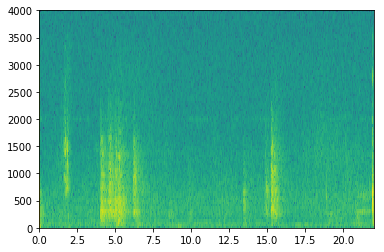

In [2]:
x = graph_spectrogram("raw_data/backgrounds/b1.wav")

In [3]:
_, data = wavfile.read("raw_data/backgrounds/b1.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (176400,)
Time steps in input after spectrogram (101, 2203)


In [4]:
Tx = 2203 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

Note that even with 4 seconds being our default training example length, 4 seconds of time can be discretized to different numbers of value. You've seen 176400 (raw audio) and 2203 (spectrogram). In the former case, each step represents  4/441000≈0.000009  seconds. In the second case, each step represents  4/2203≈0.0018  seconds.

For the 4sec of audio, the key values you will see in this assignment are:

176400  (raw audio)
2203=𝑇𝑥  (spectrogram output, and dimension of input to the neural network).
4000  (used by the pydub module to synthesize audio)
548=𝑇𝑦  (the number of steps in the output of the GRU you'll build).

Consider the  𝑇𝑦=548  number above. This means that for the output of the model, we discretize the 4s into 548 time-intervals (each one of length  4/548≈0.00073 s) and try to predict for each of these intervals whether someone recently finished saying "ethan."

Consider also the 4000 number above. This corresponds to discretizing the 4sec clip into 10/4000 = 0.001 second itervals. 0.001 seconds is also called 1 millisecond, or 1ms. So when we say we are discretizing according to 1ms intervals, it means we are using 4,000 steps.

In [5]:
Ty = 548 # The number of time steps in the output of our model

## 1.3 - Generating training examples

In [6]:
# Load audio segments using pydub 
ethan_positives, negatives, backgrounds = load_raw_audio()

print("background len: " + str(len(backgrounds[0])))    # Should be 4,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(ethan_positives[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(ethan_positives[1])))     # Different "activate" clips can have different lengths 


background len: 4000
activate[0] len: 480
activate[1] len: 790


###### Overlaying positive/negative words on the background:

Given a 4sec background clip and a short audio clip (positive or negative word), you need to be able to "add" or "insert" the word's short audio clip onto the background. To ensure audio segments inserted onto the background do not overlap, you will keep track of the times of previously inserted audio clips. You will be inserting multiple clips of positive/negative words onto the background, and you don't want to insert an "ethan" or a random word somewhere that overlaps with another clip you had previously added.

For clarity, when you insert a 1sec "ethan" onto a 4sec clip of cafe noise, you end up with a 4sec clip that sounds like someone sayng "ethan" in a cafe, with "ethan" superimposed on the background cafe noise. You do not end up with an 5 sec clip. 

###### Creating the labels at the same time you overlay:

Recall also that the labels  𝑦⟨𝑡⟩  represent whether or not someone has just finished saying "ethan." Given a background clip, we can initialize  𝑦⟨𝑡⟩=0  for all  𝑡 , since the clip doesn't contain any "ethans."

When you insert or overlay an "ethan" clip, you will also update labels for  𝑦⟨𝑡⟩ , so that 50 steps of the output now have target label 1. You will train a GRU to detect when someone has finished saying "ethan". For example, suppose the synthesized "ethan" clip ends at the 2sec mark in the 4sec audio---exactly halfway into the clip. Recall that  𝑇𝑦=548 , so timestep  274=  int(548*0.5) corresponds to the moment at 2sec into the audio. So, you will set  𝑦⟨274⟩=1 . Further, you would quite satisfied if the GRU detects "ethan" anywhere within a short time-internal after this moment, so we actually set 50 consecutive values of the label  𝑦⟨𝑡⟩  to 1. Specifically, we have  𝑦⟨274⟩=𝑦⟨275⟩=⋯=𝑦⟨323⟩=1 .

This is another reason for synthesizing the training data: It's relatively straightforward to generate these labels  𝑦⟨𝑡⟩  as described above. In contrast, if you have 4sec of audio recorded on a microphone, it's quite time consuming for a person to listen to it and mark manually exactly when "ethan" finished.

In [7]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 4,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=4000-segment_ms)   # Make sure segment doesn't run past the 4sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [8]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    # Initialize overlap as a "False" flag.
    overlap = False
    
    # loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [9]:
# Test overlap: expected output: Overlap 1 =  False, Overlap 2 =  True
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [10]:
def insert_audio_clip_by_random(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 4 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Skip audio file if it's greater than 4seconds
    if(segment_ms > 4000):
        segment_ms = 0
        
    # Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip.
    segment_time = get_random_time_segment(segment_ms)
    
    # Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap.
    counter = 0 # max 1000 random tries
    while is_overlapping(segment_time, previous_segments) and (counter<1000):
        segment_time = get_random_time_segment(segment_ms)
        counter += 1

    new_background = background
    # If a random segment fits within 1000 tries, update background. else pass back the original
    # Don't want to be trap in a potential infiite loop
    if(counter<1000):
        # Add the new segment_time to the list of previous_segments
        previous_segments.append(segment_time)

        # Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])        
    
    return new_background, segment_time

def insert_audio_clip_by_time(background, audio_clip, segment_start):
    """
    Insert a new audio segment over the background noise at time step.
    
    Arguments:
    background -- a 4 second background audio recording.  
    audio_clip -- the audio clip to be inserted. 
    segment_time -- time step where audio clip will be placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    segment_end = segment_start + segment_ms - 1
    
    new_background = background
    # Make sure segment doesn't run past the 4sec background, else return the original background
    if(segment_end < 4000):  
        # Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_start)        

    return new_background, (segment_start, segment_end)

Finally, implement code to update the labels  𝑦⟨𝑡⟩ , assuming you just inserted an "ethan." In the code below, y is a (1,548) dimensional vector, since  𝑇𝑦=548 .

If the "ethan" ended at time step  𝑡 , then set  𝑦⟨𝑡+1⟩=1  as well as for up to 49 additional consecutive values. However, make sure you don't run off the end of the array and try to update y[0][548], since the valid indices are y[0][0] through y[0][547] because  𝑇𝑦=548 . So if "ethan" ends at step 543, you would get only y[0][544] = y[0][545] = y[0][546] = y[0][547] = 1

In [11]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 4000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    
    return y

sanity checks: 0.0 1.0 0.0


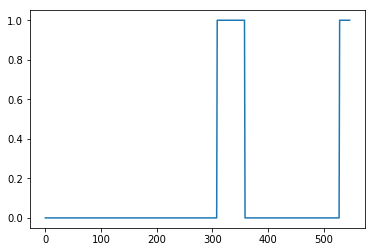

In [12]:
# Sanity Check 
arr1 = insert_ones(np.zeros((1, Ty)), 3857)
plt.plot(insert_ones(arr1, 2251)[0,:])
print("sanity checks:", arr1[0][506], arr1[0][320], arr1[0][100])

In [13]:
def create_training_example_by_time(background, audio_clip, segment_start, positive_flag=False):
    """
    Creates a training examples with the given background, audio clip (positive/negatives), segment_start.
    
    Arguments:
    backgrounds -- a 4 second background audio recordings
    audio_clip -- an audio clip of a word
    segment_start -- starting position to insert the audio clip at
    positive_flag -- a boolean to signify if the audio clip is a positive or not
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter
    background = background - 20

    # Initialize y (label vector) of zeros
    y = np.zeros((1, Ty))

    # Insert audio clip into the background at segment start
    background, segment_time = insert_audio_clip_by_time(background, audio_clip, segment_start)
    # Update y if audio clip is positive
    if(positive_flag):
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)
                
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)
    
    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    
    # Get and plot spectrogram of the new recording (background with superposition of a positive or a negative)
    x = graph_spectrogram("train.wav")
    
    return x, y

In [14]:
def create_training_example_by_random(background, positives, negatives):
    """
    Creates a training example with a given background, positives, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    positives -- a list of audio segments of the word "ethan"
    negatives -- a list of audio segments of random words that are not "ethan"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter
    background = background - 20

    # Initialize y (label vector) of zeros
    y = np.zeros((1, Ty))

    # Initialize segment times as empty list
    previous_segments = []
    
    # Select 0-2 random "ethan" audio clips from the entire list of "ethan" recordings
    number_of_positives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(positives), size=number_of_positives)
    random_positives = [positives[i] for i in random_indices]

    # Loop over randomly selected "ethan" clips and insert in background
    for random_positive in random_positives:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip_by_random(background, random_positive, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip_by_random(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)
    
    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

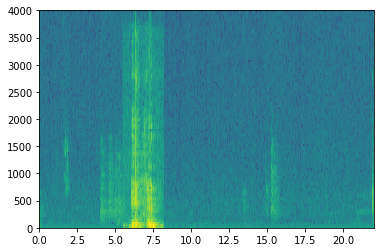

In [67]:
x, y = create_training_example_by_time(backgrounds[0], ethan_positives[4], 1000)

In [16]:
IPython.display.Audio("train.wav")

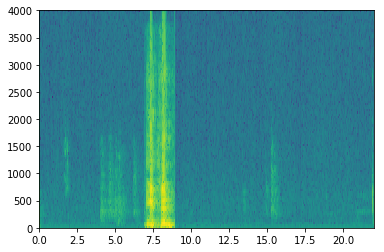

In [17]:
x, y = create_training_example_by_random(backgrounds[0], ethan_positives, negatives)

In [18]:
IPython.display.Audio("train.wav")

### Method 1:
Iterate thru List of Positives & Negatives, then insert each audio individually by time interval of 0.5 second

Starting Method 1 Training examples.
Ethan positive audio data appended: 1
Ethan positive audio data appended: 2
Ethan positive audio data appended: 3
Ethan positive audio data appended: 4
Ethan positive audio data appended: 5
Ethan positive audio data appended: 6
Ethan positive audio data appended: 7
Ethan positive audio data appended: 8
Ethan positive audio data appended: 9
Ethan positive audio data appended: 10
Ethan positive data completed. Total: 70


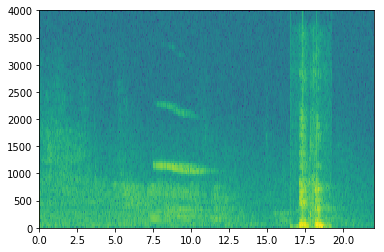

In [40]:
# Create Positive Training Examples based off Method 1
X_m1_positives = []
Y_m1_positives = []

print("Starting Method 1 Training examples.")
counter = 1
# Loop over positive "ethan" clips and insert in background
for background in backgrounds:
    for ethan_positive in ethan_positives:
        # Insert the audio clip on the background for segment_starts: 0s, 0.5s, 1s, 1.5s, 2s, 2.5s, 3s 
        for segment_start in range(0,3001,500):
            x, y = create_training_example_by_time(background, ethan_positive, segment_start, positive_flag=True)
            X_m1_positives.append(np.array(x.T))
            Y_m1_positives.append(np.array(y.T))
            
        print(f"Ethan positive audio data appended: {counter}")
        counter += 1

X_m1_positives = np.array(X_m1_positives)
Y_m1_positives = np.array(Y_m1_positives)
print(f"Ethan positive data completed. Total: {len(Y_m1_positives)}")

In [ ]:
# Save trained positives (np.array) 
np.save('XY_Train/X_m1_positives.npy', X_m1_positives)    # .npy extension is added if not given
np.save('XY_Train/Y_m1_positives.npy', Y_m1_positives)

Starting Method 1 Training examples.
Ethan negative audio data appended: 1
Ethan negative audio data appended: 2
Ethan negative audio data appended: 3
Ethan negative audio data appended: 4
Ethan negative audio data appended: 5
Ethan negative audio data appended: 6
Ethan negative audio data appended: 7
Ethan negative audio data appended: 8
Ethan negative audio data appended: 9
Ethan negative audio data appended: 10
Negative Training data completed. Total: 70


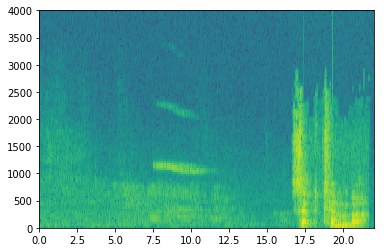

In [41]:
# Create Negative Training Examples based off Method 1
X_m1_negatives = []
Y_m1_negatives = []

# shuffle negative words
n_shuffle = np.random.permutation(len(negatives))

print("Starting Method 1 Training examples.")
counter = 1
# Loop over negative clips and insert in background
for background in backgrounds:
    for negative in negatives[n_shuffle][:(len(Y_m1_positives)//14)]:
        # Insert the audio clip on the background for segment_starts: 0s, 0.5s, 1s, 1.5s, 2s, 2.5s, 3s 
        for segment_start in range(0,3001,500):
            x, y = create_training_example_by_time(background, negative, segment_start)
            X_m1_negatives.append(np.array(x.T))
            Y_m1_negatives.append(np.array(y.T))
            
        print(f"Ethan negative audio data appended: {counter}")
        counter += 1
            
X_m1_negatives = np.array(X_m1_negatives)
Y_m1_negatives = np.array(Y_m1_negatives)
print(f"Negative Training data completed. Total: {len(Y_m1_negatives)}")

In [ ]:
# Save trained positives (np.array) 
np.save('XY_Train/X_m1_negatives.npy', X_m1_negatives)    # .npy extension is added if not given
np.save('XY_Train/Y_m1_negatives.npy', Y_m1_negatives)

In [42]:
# Concat X positives and negatives
X_m1_concat = np.concatenate([X_m1_positives, X_m1_negatives])
len(X_m1_concat)

140

In [43]:
# Concat Y positives and negatives
Y_m1_concat = np.concatenate([Y_m1_positives, Y_m1_negatives])
len(Y_m1_concat)

140

In [46]:
# Shuffle training data
assert len(X_m1_concat) == len(Y_m1_concat)
p = np.random.permutation(len(Y_m1_concat))
X_m1_concat = X_m1_concat[p]
Y_m1_concat = Y_m1_concat[p]

In [ ]:
# Take 90% for training and 10% for dev
ten_percent_length = len(Y_m1_concat)//10

Y_m1_dev = Y_m1_concat[(-ten_percent_length):]
X_m1_dev = X_m1_concat[(-ten_percent_length):]
Y_m1_concat = Y_m1_concat[:(-ten_percent_length)]
X_m1_concat = X_m1_concat[:(-ten_percent_length)]

### Method 2:
Create Random Training Examples

In [ ]:
# Create 5000 training set: 3000 with background_0 and 2000 with background_1
x, y = create_training_example_by_random(backgrounds[0], ethan_positives, negatives)
X_m2 = [np.array(x.T)]
Y_m2 = [np.array(y.T)]
print("Started Training data.")
for i in range(2999):
    x, y = create_training_example_by_random(backgrounds[0], ethan_positives, negatives)
    X_m2.append(np.array(x.T))
    Y_m2.append(np.array(y.T))
print("60% of Training data completed.")
for i in range(2000):
    x, y = create_training_example_by_random(backgrounds[1], ethan_positives, negatives)
    X_m2.append(np.array(x.T))
    Y_m2.append(np.array(y.T))

X_m2 = np.array(X_m2)
Y_m2 = np.array(Y_m2)
print("100% of Training data completed.")

In [ ]:
# Create 5000 training set: 2500 with background_0 and 2500 with background_1
x, y = create_training_example_by_random(backgrounds[0], ethan_positives, negatives)
X_m3 = [np.array(x.T)]
Y_m3 = [np.array(y.T)]
print("Started Training data.")
for i in range(2499):
    x, y = create_training_example_by_random(backgrounds[0], ethan_positives, negatives)
    X_m3.append(np.array(x.T))
    Y_m3.append(np.array(y.T))
print("50% of Training data completed.")
for i in range(2500):
    x, y = create_training_example_by_random(backgrounds[1], ethan_positives, negatives)
    X_m3.append(np.array(x.T))
    Y_m3.append(np.array(y.T))

X_m3 = np.array(X_m3)
Y_m3 = np.array(Y_m3)
print("100% of Training data completed.")

In [ ]:
# Create 300 dev training set: 200 with background_0 and 100 with background_1
x, y = create_training_example_by_random(backgrounds[0], ethan_positives, negatives)
X_m2_dev = [np.array(x.T)]
Y_m2_dev = [np.array(y.T)]
print("1% of Dev data completed.")
for i in range(199):
    x, y = create_training_example_by_random(backgrounds[0], ethan_positives, negatives)
    X_m2_dev.append(np.array(x.T))
    Y_m2_dev.append(np.array(y.T))
print("66% of Dev data completed.")
for i in range(100):
    x, y = create_training_example_by_random(backgrounds[1], ethan_positives, negatives)
    X_m2_dev.append(np.array(x.T))
    Y_m2_dev.append(np.array(y.T))
    
X_m2_dev = np.array(X_m2_dev)
Y_m2_dev = np.array(Y_m2_dev)
print("100% of Dev data completed.")

# 2 - Model

The model will use 1-D convolutional layers, GRU layers, and dense layers. 

In [51]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

## 2.1 - Build the model

Here is the architecture we will use. Take some time to look over the model and see if it makes sense. 

<img src="images/model.png" style="width:600px;height:600px;">
<center> **Figure 3** </center>

One key step of this model is the 1D convolutional step (near the bottom of Figure 3). It inputs the 2203 step spectrogram, and outputs a 1375 step output, which is then further processed by multiple layers to get the final $T_y = 1375$ step output. This layer plays a role similar to the 2D convolutions you saw in Course 4, of extracting low-level features and then possibly generating an output of a smaller dimension. 

Computationally, the 1-D conv layer also helps speed up the model because now the GRU  has to process only 1375 timesteps rather than 5511 timesteps. The two GRU layers read the sequence of inputs from left to right, then ultimately uses a dense+sigmoid layer to make a prediction for $y^{\langle t \rangle}$. Because $y$ is binary valued (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1, corresponding to the user having just said "activate."

Note that we use a uni-directional RNN rather than a bi-directional RNN. This is really important for trigger word detection, since we want to be able to detect the trigger word almost immediately after it is said. If we used a bi-directional RNN, we would have to wait for the whole 10sec of audio to be recorded before we could tell if "activate" was said in the first second of the audio clip.  

In [52]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # CONV layer
    X = Conv1D(196, 15, strides=4)(X_input)             # CONV1D
    X = BatchNormalization()(X)                         # Batch normalization
    X = Activation('relu')(X)                           # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # First GRU Layer
    X = GRU(units = 128, return_sequences = True)(X)    # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    
    # Second GRU Layer 
    X = GRU(units = 128, return_sequences = True)(X)    # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    # Time-distributed dense layer 
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [53]:
model = model(input_shape = (Tx, n_freq))

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2203, 101)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 548, 196)          297136    
_________________________________________________________________
batch_normalization_4 (Batch (None, 548, 196)          784       
_________________________________________________________________
activation_2 (Activation)    (None, 548, 196)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 548, 196)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 548, 128)          124800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 548, 128)          0         
__________

You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows

In [55]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [61]:
model.fit(X_m1_concat, Y_m1_concat, batch_size=16, epochs=100)

Epoch 1/100
140/140 [==============================] - 7s 53ms/step - loss: 0.8466 - acc: 0.8156
Epoch 2/100
140/140 [==============================] - 7s 52ms/step - loss: 0.8405 - acc: 0.8212
Epoch 3/100
140/140 [==============================] - 7s 52ms/step - loss: 0.8441 - acc: 0.8223
Epoch 4/100
140/140 [==============================] - 7s 53ms/step - loss: 0.8539 - acc: 0.8190
Epoch 5/100
140/140 [==============================] - 8s 55ms/step - loss: 0.8363 - acc: 0.8263
Epoch 6/100
140/140 [==============================] - 8s 54ms/step - loss: 0.8378 - acc: 0.8227
Epoch 7/100
140/140 [==============================] - 8s 55ms/step - loss: 0.8305 - acc: 0.8292
Epoch 8/100
140/140 [==============================] - 8s 55ms/step - loss: 0.8488 - acc: 0.8255
Epoch 9/100
140/140 [==============================] - 8s 55ms/step - loss: 0.8393 - acc: 0.8286
Epoch 10/100
140/140 [==============================] - 8s 56ms/step - loss: 0.8499 - acc: 0.8213
Epoch 11/100
140/140 [=======

140/140 [==============================] - 7s 53ms/step - loss: 0.8078 - acc: 0.8492
Epoch 85/100
140/140 [==============================] - 7s 53ms/step - loss: 0.8056 - acc: 0.8467
Epoch 86/100
140/140 [==============================] - 7s 53ms/step - loss: 0.8091 - acc: 0.8500
Epoch 87/100
140/140 [==============================] - 7s 53ms/step - loss: 0.8110 - acc: 0.8454
Epoch 88/100
140/140 [==============================] - 7s 52ms/step - loss: 0.8076 - acc: 0.8511
Epoch 89/100
140/140 [==============================] - 7s 53ms/step - loss: 0.8044 - acc: 0.8575
Epoch 90/100
140/140 [==============================] - 7s 53ms/step - loss: 0.8127 - acc: 0.8504
Epoch 91/100
140/140 [==============================] - 7s 53ms/step - loss: 0.8049 - acc: 0.8514
Epoch 92/100
140/140 [==============================] - 7s 52ms/step - loss: 0.8071 - acc: 0.8500
Epoch 93/100
140/140 [==============================] - 7s 53ms/step - loss: 0.8020 - acc: 0.8558
Epoch 94/100
140/140 [===========

In [ ]:
model.fit(X_m2, Y_m2, batch_size=4, epochs=1)

In [62]:
loss, acc = model.evaluate(X_m1_dev, Y_m1_dev)
print("Dev set accuracy = ", acc)

14/14 [==============================] - 0s 15ms/step
Dev set accuracy =  1.0


In [76]:
# Save the model weights
model.save_weights("./models/ethan_model.h5")

# 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

<!--
can use your model to make predictions on new audio clips.

You will first need to compute the predictions for an input audio clip.

**Exercise**: Implement predict_activates(). You will need to do the following:

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. Use forward propagation on your model to compute the prediction at each output step
!-->

In [70]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [106]:
x = X_m1_dev[0]
x = np.expand_dims(x, axis=0)
predictions = model.predict(x)
predictions

array([[[0.41492447],
        [0.42370337],
        [0.42841297],
        [0.43088242],
        [0.43214017],
        [0.43275613],
        [0.4330412 ],
        [0.43316162],
        [0.4332042 ],
        [0.43321276],
        [0.43320832],
        [0.4332005 ],
        [0.43319303],
        [0.43318713],
        [0.43318292],
        [0.43318006],
        [0.4331782 ],
        [0.43317696],
        [0.43317625],
        [0.4331758 ],
        [0.43317553],
        [0.4331754 ],
        [0.43317533],
        [0.43317524],
        [0.43317524],
        [0.43317524],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0.43317518],
        [0

(1, 2203, 101)

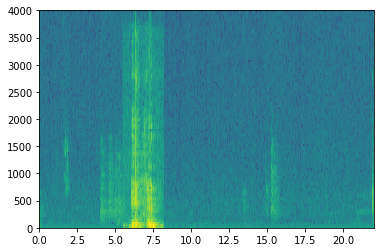

In [103]:
x = graph_spectrogram("./train.wav")
# the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
x  = x.swapaxes(0,1)
x = np.expand_dims(x, axis=0)
x.shape

In [71]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

In [72]:
IPython.display.Audio("./train.wav")

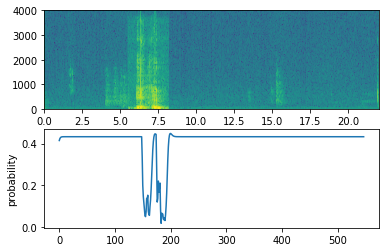

In [73]:
#filename = "./raw_data/dev/1.wav"
filename = "train.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.8)
IPython.display.Audio("./chime_output.wav")